# MID-SEM-------AML Course

### Submitted by- Hemant Yadav (PhD20017)

In [38]:
from sklearn.datasets import fetch_openml
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.manifold import TSNE
import pandas as pd 
from sklearn.metrics.cluster import adjusted_rand_score, adjusted_mutual_info_score, normalized_mutual_info_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import json

# Loading the dataset
try: 
    x = np.load("x.npy")
    y = np.load("y.npy")
    
except: 
    dataset = fetch_openml("mnist_784")

    x, y = [], []
    keys = ['0', '1', '2', '3', '4']

    for k in tqdm(keys):
        count = 0
        for d,t in zip(dataset['data'], dataset['target']): 
            if t == k:
                x.append(np.array(d))
                y.append(k)
                count+= 1
                if count == 200: break
    np.save('x.npy',x)
    np.save('y.npy',y)

    assert len(set(y)) == 5 and len(x) == 1000

In [39]:
#  PCA to perform dimensionality reduction by retaining upto 95% of the total energy

energy = 0
for i in tqdm(range(768)):
    pca = PCA(n_components=i)
    pca.fit(x)
    energy = sum(pca.explained_variance_ratio_)
    if energy >=0.950:
        print(i)
        break
print(energy)
# i=121        
pca = PCA(n_components=i)
X = pca.fit_transform(x)


### Sk-learn Kmeans Method

In [40]:
ari, ami, nmi =0,0,0
for i in range(10):
    km = KMeans(
        n_clusters=5, init='random',
        n_init=1, max_iter=500, 
        tol=1e-04, random_state=1
    )
    y_km = km.fit_predict(X)
    ari += adjusted_rand_score(y,y_km)
    ami += adjusted_mutual_info_score(y,y_km)
    nmi += normalized_mutual_info_score(y,y_km)

print(f"Average SK-learn score: \n\tari:{ari/10} \n\tami:{ami/10} \n\tnmi:{nmi/10}")

km = KMeans(
        n_clusters=5, init='random',
        n_init=10, max_iter=500, 
        tol=1e-04, random_state=1
    )
y_km = km.fit_predict(X)
ari = adjusted_rand_score(y,y_km)
ami = adjusted_mutual_info_score(y,y_km)
nmi = normalized_mutual_info_score(y,y_km)

print(f"Best SK-learn score: \n\tari:{ari} \n\tami:{ami} \n\tnmi:{nmi}")

Average SK-learn score: 
	ari:0.47761150426329213 
	ami:0.5367069432252782 
	nmi:0.539052051578179
Best SK-learn score: 
	ari:0.6455628726644921 
	ami:0.6503199550725477 
	nmi:0.652083649955982


<!-- ### Tsne -->

### T-sne plot for the sk-learn method

In [41]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300,n_jobs=4)
tsne_results = tsne.fit_transform(X)

data = {'tsne-2d-one': tsne_results[:,0], 'tsne-2d-two': tsne_results[:,1], 'y': y_km.astype('U1')}
df = pd.DataFrame(data) 

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.011s...
[t-SNE] Computed neighbors for 1000 samples in 0.165s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 655.894380
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.297417
[t-SNE] KL divergence after 300 iterations: 0.878083


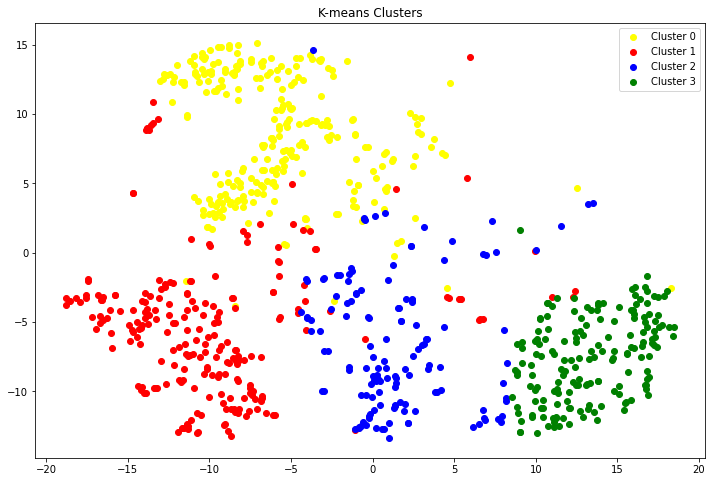

In [45]:
plt.figure(figsize=(12,8))
plt.scatter(df[df['y'] == '0']['tsne-2d-one'], df[df['y'] == '0']['tsne-2d-two'], c = 'yellow', label = 'Cluster 0')
plt.scatter(df[df['y'] == '1']['tsne-2d-one'], df[df['y'] == '1']['tsne-2d-two'], c = 'red', label = 'Cluster 1')
plt.scatter(df[df['y'] == '2']['tsne-2d-one'], df[df['y'] == '2']['tsne-2d-two'], c = 'blue', label = 'Cluster 2')
plt.scatter(df[df['y'] == '3']['tsne-2d-one'], df[df['y'] == '3']['tsne-2d-two'], c = 'green', label = 'Cluster 3')
plt.title('K-means Clusters')
plt.xlabel('')
plt.ylabel('')
plt.legend()
plt.savefig('tsne-sklearn.png')
plt.show()

### kernelized K-means implementation

In [46]:
# Distance computation

def compute_dist_mean(p_1, p_m,d):
    n = len(p_m) + 1
    d_2 = d * (1 / n**2)
    d_3 = sum([k_lin[p_1,i] for i in p_m]) * (2/n) 

    return k_lin[p_1,p_1] + d_2 - d_3

# For early stopping, if the centroids does not chage much
def mean(p):
    return np.mean( np.array( [X[i] for i in p] ), axis=0 )

In [51]:
# K-means Algorithm using the Kernel matrix formulation

num_clusters = 5 # number of clusters
iteration = 1000 # number of iterations
n_k_means = 10 # no of times to run k-means
kernel = 'linear'
# kernel = 'rbf'

scale = [10**(-i) for i in range(10)] + [i for i in np.arange(1.1,5,1)]
# scale = [0.0000001]

score_ = {}

for sig in scale:
    # K_lin matrix formation
    k_lin = []
    for i in tqdm(X):
        dummy = []
        for j in X:
            if kernel == "linear" : dummy.append(np.dot(i,j))
            elif kernel == "rbf" : dummy.append(np.exp(-sig * (np.linalg.norm(i - j)**2) ))
        k_lin.append(dummy)
    k_lin = np.array(k_lin)

    dummy_ = {'ari': [], 'ami': [], 'nmi': []}
    
    for runs in tqdm(range(n_k_means)):
        # initialize centroids
        centroids = {i:j for i,j in enumerate(np.random.choice(len(X), num_clusters, replace=False))}
        s = True
        # print(centroids)

        for iter_ in range(iteration):
            label = {i:[] for i in centroids.keys()}
            
            for i in range(len(X)):
                distance = {}
                for c,j in centroids.items():
                    if s: distance[c] = k_lin[i,j] + k_lin[j,j] - 2*k_lin[i,j]
                    else: distance[c] = compute_dist_mean(i,j,dummy[c])
                label[min(distance.items(), key= lambda x: x[-1])[0]].append(i)
            
            if not s :
#                     print(sum([sum(mean(label[i]) - mean(centroids[i])) for i in range(5)]))
                if abs(sum([sum(mean(label[i]) - mean(centroids[i])) for i in range(5)])) <= 1e-8:
                    centroids = label
                    break
                
            centroids = label
            dummy = {k:sum([k_lin[i,j] for i in v for j in v]) for k,v in centroids.items()}
            s = False

        a = {}
        for i in centroids:
            for j in centroids[i]:
                a[j]=i
        a = [i[-1] for i in sorted(a.items())]
        
        dummy_['ari'].append(adjusted_rand_score(y,a))
        dummy_['ami'].append(adjusted_mutual_info_score(y,a))
        dummy_['nmi'].append(normalized_mutual_info_score(y,a))
        if kernel == 'linear': score_['linear-'] = dummy_
        else: score_[f"RBF-{str(sig)}"] = dummy_
            
            
    if kernel == 'linear': break

        
# sorting the best scale value
dummy = {}
d,k_ = 1e-100,' '
for k,v in score_.items():
    if sum(v['ari']) > d: 
        d = sum(v['ari'])
        k_ = k
        dummy = v
        
# saving the results
# with open(f"{kernel}.json", "w") as f:
#     json.dump({k_:dummy},f)


In [52]:
# Loading and printing the resutls

# kernel = 'linear'
# kernel = 'rbf'

with open(f"{kernel}.json", "r") as f:
    results = json.loads(f.read())

for sig,score in results.items():
    print(f"Kernel : {sig}")
    print(f"\taverage score \n\t\tari:{sum(score['ari'])/n_k_means} \n\t\tami:{sum(score['ami'])/n_k_means} \n\t\tnmi:{sum(score['nmi'])/n_k_means}")
    print(f"\tbest score \n\t\tari:{max(score['ari'])} \n\t\tami:{max(score['ami'])} \n\t\tnmi:{max(score['nmi'])}")

Kernel : RBF-1e-07
	average score 
		ari:0.5927776801298006 
		ami:0.6272365769699179 
		nmi:0.6291340521825739
	best score 
		ari:0.7314759906652513 
		ami:0.7174464024167231 
		nmi:0.7188628343340469


### T-sne plot for the kernalization method

In [53]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X)

data = {'tsne-2d-one': tsne_results[:,0], 'tsne-2d-two': tsne_results[:,1], 'y': np.array(a).astype('U1')}
df = pd.DataFrame(data) 

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.013s...
[t-SNE] Computed neighbors for 1000 samples in 0.299s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 655.894380
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.144852
[t-SNE] KL divergence after 300 iterations: 0.907826


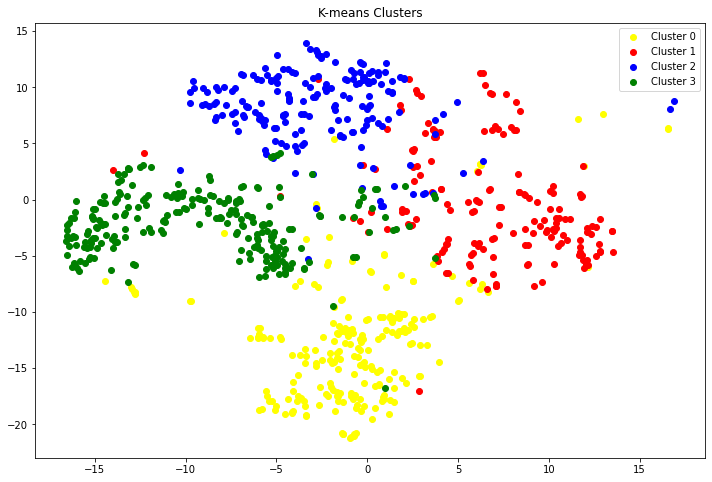

In [54]:

plt.figure(figsize=(12,8))
plt.scatter(df[df['y'] == '0']['tsne-2d-one'], df[df['y'] == '0']['tsne-2d-two'], c = 'yellow', label = 'Cluster 0')
plt.scatter(df[df['y'] == '1']['tsne-2d-one'], df[df['y'] == '1']['tsne-2d-two'], c = 'red', label = 'Cluster 1')
plt.scatter(df[df['y'] == '2']['tsne-2d-one'], df[df['y'] == '2']['tsne-2d-two'], c = 'blue', label = 'Cluster 2')
plt.scatter(df[df['y'] == '3']['tsne-2d-one'], df[df['y'] == '3']['tsne-2d-two'], c = 'green', label = 'Cluster 3')
plt.title('K-means Clusters')
plt.xlabel('')
plt.ylabel('')
plt.legend()
plt.savefig('tsne-rbf-K.png')
plt.show()

# END